In [283]:
import time
import scipy
import numpy as np
import pandas as pd
import winsound

import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import tensor
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR as OCR
from torch.utils.data import RandomSampler, SequentialSampler

import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData
from torch_geometric.nn import HGTConv, SAGEConv, GATConv, Linear, to_hetero
from torch_geometric.nn import models as pyg_models
from torch_geometric.sampler import HGTSampler
from torch_geometric.loader import DataLoader, HGTLoader, NeighborLoader, NodeLoader
from tqdm import tqdm

from HeteroDataFunctions import Encoder, add_types, complete_graph, flatten_lol, node_cat_dict, midi_type, plot_graph, plot_4graphs

# print(scipy.__version__)
# print(matplotlib.__version__)
# print(nx.__version__)
print(torch.__version__)

2.0.0+cu118


In [97]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 960
Memory Usage:
Allocated: 0.2 GB
Cached:    0.6 GB


In [98]:
# # Complete Dataset
# G = complete_graph(".\slac\embeddings\\all")
# nx.write_edgelist(G, ".\slac\homograph.edgelist", data=False)

In [99]:
G = nx.read_edgelist(".\slac\homograph.edgelist")

In [100]:
nodes = pd.DataFrame((list(G.nodes)), columns=['name'])
edges = pd.DataFrame(np.array(list(G.edges)), columns=['source', 'target'])

In [101]:
node_categories = node_cat_dict(nodes)
node_categories.keys()

node_cat_dict took 0.18 secs to run


dict_keys(['note_group', 'pitch', 'program', 'MIDI', 'duration', 'velocity', 'time_sig', 'tempo'])

In [102]:
%%script false --no- raise -error

nodes_df_complete, edges_df_complete = add_types(nodes, edges, node_categories)

winsound.Beep(400, 700)

nodes_df_complete.to_csv('nodes_complete.csv')
edges_df_complete.to_csv('edges_complete.csv')

Couldn't find program: 'false'


In [103]:
nodes_df_complete = pd.read_csv('.\slac\Contents of Slac\\nodes_complete.csv')
edges_df_complete = pd.read_csv('.\slac\Contents of Slac\edges_complete.csv')
print('Done')

Done


In [104]:
node_types = set(nodes_df_complete['node_type'])
node_types


{'MIDI',
 'duration',
 'note_group',
 'pitch',
 'program',
 'tempo',
 'time_sig',
 'velocity'}

In [105]:
edge_types = ["MIDI__has__tempo",
                   "MIDI__in__time_sig",
                   "MIDI__has__program",
                   "MIDI__has__note_group",
                   "note_group__has__velocity",
                   "note_group__has__duration",
                   "note_group__contains__pitch"]

In [106]:
names_list = flatten_lol(node_categories.values())


In [107]:
encoder = Encoder(names_list, n_labels=10)


In [108]:
input_node_dict = {node_type: {'x': encoder.
                    encode_nodes(nodes_df_complete.
                    loc[nodes_df_complete['node_type'] == node_type, ['name']])}
                    for node_type in node_types}

encode_nodes took 0.02 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 0.01 secs to run
encode_nodes took 0.00 secs to run
encode_nodes took 3.33 secs to run


In [109]:
node_enc_to_idx = {node_type: {encoder.decode_value(node_enc.item()): i for i, node_enc in enumerate(input_node_dict[node_type]['x'])} for node_type in node_types}

In [110]:
input_edge_dict = dict()
for edge_type in edge_types:
    node_type_s, node_type_t = edge_type.split('__')[0], edge_type.split('__')[2]

    edge_df = edges_df_complete.loc[edges_df_complete['edge_type'] == edge_type, ['source', 'target']].copy()

    edge_df['source'], edge_df['target'] = edge_df['source'].map(node_enc_to_idx[node_type_s]), edge_df['target'].map(node_enc_to_idx[node_type_t])

    input_edge_dict[edge_type] = {'edge_index': torch.tensor(edge_df.values).T}


In [111]:
# Extract the label of each Midi.
midi_val = nodes_df_complete.loc[nodes_df_complete['node_type'] == 'MIDI', ['name']].values
midi_class_5 = [midi_type(s[0], 5) for s in midi_val]

lb = LabelEncoder()
y_5 = torch.from_numpy(lb.fit_transform(midi_class_5)) # .type(torch.LongTensor)

lb.classes_

array(['Blues', 'Classical', 'Jazz', 'Rap', 'Rock'], dtype='<U9')

In [112]:
input_node_dict_5 = input_node_dict.copy()

input_node_dict_5['MIDI']['y'] = y_5

In [113]:
# H_5 = HeteroData(input_node_dict_5, **input_edge_dict).to(device)
# torch.save(H_5, '.\slac\H_5.pt')

In [284]:
H_5 = torch.load('.\slac\H_5.pt')

In [285]:
print(H_5)

HeteroData(
  program={ x=[108, 1] },
  tempo={ x=[23, 1] },
  MIDI={
    x=[250, 1],
    y=[250]
  },
  pitch={ x=[93, 1] },
  note_group={ x=[92484, 1] },
  velocity={ x=[11, 1] },
  time_sig={ x=[14, 1] },
  duration={ x=[570, 1] },
  (MIDI, has, tempo)={ edge_index=[2, 250] },
  (MIDI, in, time_sig)={ edge_index=[2, 239] },
  (MIDI, has, program)={ edge_index=[2, 1392] },
  (MIDI, has, note_group)={ edge_index=[2, 135160] },
  (note_group, has, velocity)={ edge_index=[2, 118626] },
  (note_group, has, duration)={ edge_index=[2, 92484] },
  (note_group, contains, pitch)={ edge_index=[2, 438484] }
)


In [286]:
H_5 = T.ToUndirected()(H_5)

In [117]:
# H_5 = T.RandomNodeSplit(num_val=0.1, num_test=0.1)(H_5)


# GNN

In [273]:
def cross_val(dataset, model, folds, epochs, lr, late_start, patience, min_delta, sched_max_lr, sched_steps, div_factor=25, final_div_factor=1e4, sched=False, lr_decay_factor=None, lr_decay_step_size=None, weight_decay=0.):
    val_losses, accs, durations, models, training_epochs = [], [], [], [], []
    print(f'Transfering dataset to device {device}')
    dataset = dataset.to(device)
    print('Done')
    print('_' * 80)
    print('Starting Cross Validation')
    print('_' * 80)

    scheduler = None

    for fold, (train_idx, test_idx,
               val_idx) in enumerate(zip(*k_fold(dataset, folds))):
        dataset['MIDI'].train_mask = train_idx
        dataset['MIDI'].val_mask = val_idx
        dataset['MIDI'].test_mask = test_idx

        
        early_stopper = EarlyStopper(patience=patience, min_delta=min_delta, late_start=late_start)

        # train_dataset = dataset['MIDI'].x[dataset['MIDI'].train_mask]
        # train_dataset = train_dataset.to(device)
        # train_label = dataset['MIDI'].y[dataset['MIDI'].train_mask]
        # train_label = train_label.to(device)

        # test_dataset = dataset['MIDI'].x[dataset['MIDI'].test_mask]
        # test_dataset = test_dataset.to(device)
        # test_label = dataset['MIDI'].y[dataset['MIDI'].test_mask]
        # test_label = test_label.to(device)

        # val_dataset = dataset['MIDI'].x[dataset['MIDI'].val_mask]
        # val_dataset = val_dataset.to(device)
        # val_label = dataset['MIDI'].y[dataset['MIDI'].val_mask]
        # val_label = val_label.to(device)

        print(f'Transfering Model to device{device}')
        model = model.to(device)
        
        print('Resetting parameters')
        reset_parameters_(model, dataset)
        

        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        if sched:
            scheduler = OCR(optimizer, max_lr=sched_max_lr, 
        total_steps=sched_steps, div_factor=div_factor, final_div_factor=final_div_factor, anneal_strategy='linear')
        loss_fn = F.cross_entropy

        print('Synchronizing GPU')
        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_start = time.perf_counter()

        print('Starting Training')
        for epoch in range(1, epochs + 1):
            train_loss = train_(model, optimizer, scheduler=scheduler, loss_fn=loss_fn, dataset=dataset, epoch=epoch, epochs=epochs)
            val_losses.append(eval_loss_(model, loss_fn, dataset))
            accs.append(eval_acc_(model, dataset))
            eval_info = {
                'fold': fold,
                'epoch': epoch,
                'train_loss': train_loss,
                'val_loss': val_losses[-1],
                'test_acc': accs[-1],
            }

            print_dict(eval_info)

            
            if lr_decay_factor:
                if epoch  >= (epochs * 0.8) and epoch % 10 == 0:
                    for param_group in optimizer.param_groups:
                        param_group['lr'] = lr_decay_factor * param_group['lr']

            if early_stopper.early_stop(val_losses[-1], epoch=epoch):
                val_losses = val_losses + [float('inf')] * (epochs - epoch)
                accs = accs + [float('NaN')] * (epochs - epoch)
                print('Early Stopping at epoch', epoch)
                break

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_end = time.perf_counter()
        durations.append(t_end - t_start)
        models.append(model)
        training_epochs.append(epoch)

    loss, acc, duration, training_epochs = tensor(val_losses), tensor(accs), tensor(durations), tensor(training_epochs, dtype=torch.float32)
    loss, acc = loss.view(folds, epochs), acc.view(folds, epochs)
    loss, argmin = loss.min(dim=1)
    acc = acc[torch.arange(folds, dtype=torch.long), argmin]

    loss_mean = loss.mean().item()
    acc_mean = acc.mean().item()
    acc_std = acc.std().item()
    duration_mean = duration.mean().item()
    training_epochs_mean = training_epochs.mean().item()
    print(f'Val Loss: {loss_mean:.4f}, Test Accuracy: {acc_mean:.3f} '
          f'± {acc_std:.3f}, Average Training Length: {training_epochs_mean},Average Duration per fold: {duration_mean/60:.3f} mins')

    return loss_mean, acc_mean, models

def k_fold(dataset, folds):
    skf = KFold(folds, shuffle=True, random_state=42, )

    test_indices, train_indices = [], []
    for _, idx in skf.split(torch.zeros(len(dataset['MIDI'].x)), dataset['MIDI'].y):
        test_indices.append(torch.from_numpy(idx).to(torch.long))

    val_indices = [test_indices[i - 1] for i in range(folds)]


    for i in range(folds):
        train_mask = torch.ones(len(dataset['MIDI'].x), dtype=torch.bool)
        train_mask[test_indices[i]] = 0
        train_mask[val_indices[i]] = 0
        train_indices.append(train_mask.nonzero(as_tuple=False).view(-1))

    return train_indices, test_indices, val_indices

def train_(model, optimizer, loss_fn, dataset, epoch, epochs,scheduler=None):
    model.train()
    
    optimizer.zero_grad()
    out = model(dataset.x_dict, dataset.edge_index_dict)

    mask = dataset['MIDI'].train_mask
    loss = loss_fn(out['MIDI'][mask], dataset['MIDI'].y[mask])
    loss.backward()
    optimizer.step()
    if scheduler and epoch <= epochs*0.8:
        scheduler.step()
    
    return float(loss)


def eval_acc_(model, dataset):
    model.eval()

    
    mask = dataset['MIDI'].test_mask

    with torch.no_grad():
        pred = model(dataset.x_dict, dataset.edge_index_dict)['MIDI'].argmax(dim=-1)

    y_true = dataset['MIDI'].y[mask].to('cpu').numpy()
    y_pred = pred[mask].to('cpu').numpy()
    
    acc = np.sum(np.equal(y_true, y_pred)) / len(y_true)
    # accs = int((pred[mask] == dataset['MIDI'].y[mask]).sum()) / int(mask.sum())

    return acc


def eval_loss_(model, loss_fn, dataset):
    model.eval()

    
    mask = dataset['MIDI'].val_mask
    with torch.no_grad():
        out = model(dataset.x_dict, dataset.edge_index_dict)
    loss = loss_fn(out['MIDI'][mask], dataset['MIDI'].y[mask])
    return (float(loss))

def reset_parameters_(model, dataset):
    print('Lazy Initialization of Model')
    with torch.no_grad():  # Initialize lazy modules.
        out = model(dataset.x_dict, dataset.edge_index_dict)

    for c in model.children():
        if isinstance(c, torch.nn.ModuleList):
            for d in c:
                for v in d.values():
                    if isinstance(v, SAGEConv):
                        nn.init.kaiming_normal_(v.lin_l.weight, nonlinearity='relu')
        
    # for c in model.children():
    #     for v in c.values():
    #         if isinstance(v, SAGEConv):
    #             print('Resetting SAGEConv')
    #             nn.init.kaiming_normal_(v.lin_l.weight, nonlinearity='relu')
    #         elif isinstance(c, Linear):
    #             print('Resetting Linear')
    #             nn.init.xavier_normal_(v.weight)
    


def print_dict(d):
    # I want a function that prints the key:values of a dictionary, all in the same line by using a final output string.
    for k, v in d.items():
        print(k, ':', v, end=' | ')
    print('\n' + '-' * 80)



class EarlyStopper:
    def __init__(self, patience=1, min_delta=0, late_start=0):
        self.late_start = late_start
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss, epoch):
        if epoch > self.late_start:
            if validation_loss < self.min_validation_loss:
                self.min_validation_loss = validation_loss
                self.counter = 0
            elif validation_loss > (self.min_validation_loss + self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    return True
        return False


In [267]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, drop_layer: bool=False, drop_rate: float=0.5):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), hidden_channels)
        self.lin1 = Linear(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)
        self.drop = drop_layer
        self.drop_rate = drop_rate

    def forward(self, x, edge_index):
        if self.drop:
            x = F.dropout(x, p=self.drop_rate, training=self.training)
            x = self.conv2(x, edge_index).relu()
            x = F.dropout(x, p=self.drop_rate, training=self.training)
            x = self.conv1(x, edge_index).relu()
            x = F.dropout(x, p=self.drop_rate, training=self.training)
            x = self.lin1(x).relu()
            x = self.lin(x)

        else:
            x = self.conv1(x, edge_index).relu()
            x = self.conv2(x, edge_index).relu()
            x = self.lin(x)
        return x


In [355]:
def lr_finder(model, dataset, start_lr, end_lr, num_iters):
    # Set up a training loop
    dataset = dataset.to(device)
    model = model.to(device)
    reset_parameters_(model, dataset)
    loss_fn = nn.CrossEntropyLoss()

    # Initialize optimizer with an initial learning rate
    optimizer = Adam(model.parameters(), lr=start_lr)
    lr_rates = []
    losses = []
    lr = start_lr

    for iteration in range(num_iters):
        # Set the learning rate for the optimizer
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # Train the model
        model.train()
        optimizer.zero_grad()
        out = model(dataset.x_dict, dataset.edge_index_dict)

        loss = loss_fn(out['MIDI'], dataset['MIDI'].y)
        loss.backward()
        optimizer.step()

        # Track the learning rate and loss
        lr_rates.append(lr)
        losses.append(loss.item())

        # Adjust the learning rate
        lr = lr * (end_lr / start_lr) ** (1 / num_iters)
        print(f'Iteration {iteration}. Learning rate: {lr:.2e}. Loss: {loss.item():.2f}')

    # Plot the learning rate vs. loss curve
    plt.plot(lr_rates, losses)
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.show()

    # Choose the optimal learning rate
    optimal_lr = lr_rates[losses.index(min(losses))]
    print("Optimal Learning Rate:", optimal_lr)
    

In [339]:
# model_5 = GCN(hidden_channels=64, out_channels=len(set(lb.classes_)), drop_layer=True, drop_rate=0.5)

model_5 = pyg_models.GraphSAGE(in_channels=-1, hidden_channels=64, num_layers=2, out_channels=len(set(lb.classes_)))
model_5 = to_hetero(model_5, H_5.metadata(), aggr='sum')


# model_5.to(device)
# model_5 = torch_geometric.compile(model_5)

Lazy Initialization of Model
Iteration 0. Learning rate: 1.06e-05. Loss: 250043.47
Iteration 1. Learning rate: 1.12e-05. Loss: 249248.12
Iteration 2. Learning rate: 1.19e-05. Loss: 248405.72
Iteration 3. Learning rate: 1.26e-05. Loss: 247513.55
Iteration 4. Learning rate: 1.33e-05. Loss: 246568.28
Iteration 5. Learning rate: 1.41e-05. Loss: 245567.11
Iteration 6. Learning rate: 1.50e-05. Loss: 244506.45
Iteration 7. Learning rate: 1.58e-05. Loss: 243383.20
Iteration 8. Learning rate: 1.68e-05. Loss: 242193.22
Iteration 9. Learning rate: 1.78e-05. Loss: 240932.83
Iteration 10. Learning rate: 1.88e-05. Loss: 239597.75
Iteration 11. Learning rate: 2.00e-05. Loss: 238183.55
Iteration 12. Learning rate: 2.11e-05. Loss: 236685.62
Iteration 13. Learning rate: 2.24e-05. Loss: 235098.86
Iteration 14. Learning rate: 2.37e-05. Loss: 233418.09
Iteration 15. Learning rate: 2.51e-05. Loss: 231637.62
Iteration 16. Learning rate: 2.66e-05. Loss: 229751.77
Iteration 17. Learning rate: 2.82e-05. Loss: 2

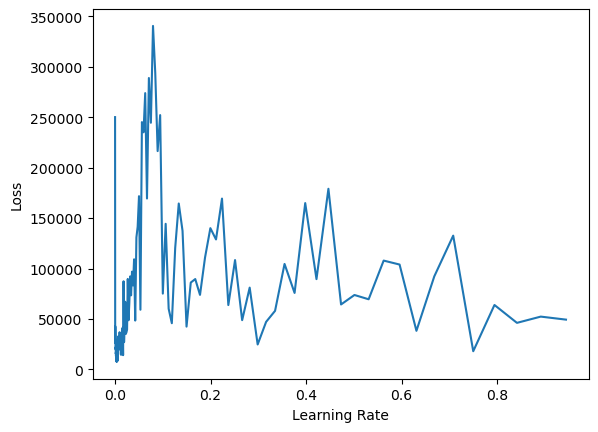

Optimal Learning Rate: 0.0033496543915782773


In [346]:
lr_finder(model=model_5, dataset=H_5, start_lr=1e-5, end_lr=1, num_iters=200)

In [320]:
# model_5 = GCN(hidden_channels=64, out_channels=len(set(lb.classes_)), drop_layer=True, drop_rate=0.5)

model_5 = pyg_models.GraphSAGE(in_channels=-1, hidden_channels=64, num_layers=2, out_channels=len(set(lb.classes_)))
model_5 = to_hetero(model_5, H_5.metadata(), aggr='sum')


# model_5.to(device)
# model_5 = torch_geometric.compile(model_5)

In [321]:
loss_mean, acc_mean, models = cross_val(
    dataset=H_5,
    model=model_5,
    folds=10,
    epochs=800,
    lr=0.002,
    sched_max_lr=0.002,
    div_factor=2,  # init_lr = max_lr/div_factor 
    final_div_factor=2, # min_lr = init_lr/final_div_factor
    sched_steps=600,
    sched=True,
    weight_decay=0.0005,
    late_start=800,
    patience=50,
    min_delta=10,
    lr_decay_factor=0.5,
)




# lr_decay_factor=0.5,
# lr_decay_step_size=50,
# weighbt_decay=0.0005

Transfering dataset to device cuda
Done
________________________________________________________________________________
Starting Cross Validation
________________________________________________________________________________
Transfering Model to devicecuda
Resetting parameters
Lazy Initialization of Model
Synchronizing GPU
Starting Training
fold : 0 | epoch : 1 | train_loss : 794709.6875 | val_loss : 764006.0625 | test_acc : 0.24 | 
--------------------------------------------------------------------------------
fold : 0 | epoch : 2 | train_loss : 732340.75 | val_loss : 697745.125 | test_acc : 0.24 | 
--------------------------------------------------------------------------------
fold : 0 | epoch : 3 | train_loss : 669969.75 | val_loss : 631458.9375 | test_acc : 0.24 | 
--------------------------------------------------------------------------------
fold : 0 | epoch : 4 | train_loss : 607564.875 | val_loss : 565117.375 | test_acc : 0.24 | 
------------------------------------------

KeyboardInterrupt: 

In [ ]:
save_models(models, '.\\slac\\models_5\\')

Models saved to .\slac\models_5\


In [ ]:
model_5 = pyg_models.GraphSAGE(in_channels=-1, hidden_channels=64, num_layers=2, out_channels=len(set(lb.classes_)))
model_5 = to_hetero(model_5, H_5.metadata(), aggr='sum')
models_5 = load_models('.\\slac\\models_5\\', model_5, 10)
models_5

In [ ]:
winsound.Beep(400, 700)

In [222]:
def voting(models, dataset):
    dataset = T.RandomNodeSplit(num_val=0.1, num_test=0.2)(dataset)
    mask = dataset['MIDI'].test_mask
    test_predictions = get_predictions(models, dataset, mask)

    # Combine predictions using voting
    stacked_predictions = torch.stack(test_predictions)
    voted_predictions, _ = torch.mode(stacked_predictions, dim=0)

    # Convert to numpy array
    return voted_predictions.to('cpu').numpy(), mask
    

def get_predictions(models, dataset, mask):
    predictions = []
    for model in models:
        model.to(device)
        model.eval()
        with torch.no_grad():
            outputs = model(dataset.x_dict, dataset.edge_index_dict)['MIDI'].argmax(dim=-1)[mask]
            predictions.append(outputs)
    return predictions

In [ ]:
predicted, mask = voting(models, H_5)

predicted


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4], dtype=int64)

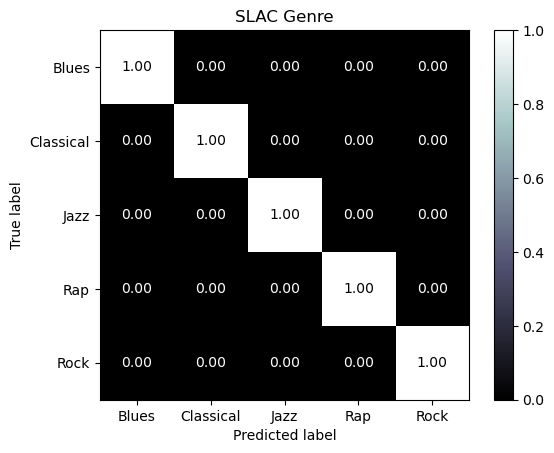

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_true=lb.inverse_transform(H_5['MIDI'].y[mask].to('cpu')), y_pred=lb.inverse_transform(predicted), cmap='bone', normalize='true', values_format='.2f')

disp.ax_.set_title('SLAC Genre')
plt.show()

# 10 Genre Exp


In [322]:
nodes_df_complete.loc[nodes_df_complete['node_type'] == 'MIDI', ['name']]

,name
0,Blues_-_Modern-Albert_King_-_Born_Under_A_Bad_...
1029,Blues_-_Modern-B_B_King_-_How_Blue_Can_You_Get
2248,Blues_-_Modern-B_B_King_-_Rock_Me_Baby
2686,Blues_-_Modern-B_B_King_-_The_Thrill_Is_Gone
3738,Blues_-_Modern-Buddy_Guy_-_Don't_Answer_the_Door
...,...
92865,Rock_-_Metal-Rage_Against_the_Machine_-_Bulls_...
92925,Rock_-_Metal-Rage_Against_the_Machine_-_Gueril...
93030,Rock_-_Metal-Rage_Against_the_Machine_-_Killin...
93133,Rock_-_Metal-Rage_Against_the_Machine_-_Know_Y...


In [323]:
set([midi_type(s[0], 10) for s in midi_val])

{'Alternative',
 'Baroque',
 'Bop',
 'Hardcore_Rap',
 'Metal',
 'Modern',
 'Pop_Rap',
 'Romantic',
 'Swing',
 'Traditional'}

In [324]:
midi_class_10 = [midi_type(s[0], 10) for s in midi_val]

lb_10 = LabelEncoder()
y_10 = torch.from_numpy(lb_10.fit_transform(midi_class_10))  # .type(torch.LongTensor)

lb_10.classes_

array(['Alternative', 'Baroque', 'Bop', 'Hardcore_Rap', 'Metal', 'Modern',
       'Pop_Rap', 'Romantic', 'Swing', 'Traditional'], dtype='<U12')

In [325]:
input_node_dict_10 = input_node_dict.copy()

input_node_dict_10['MIDI']['y'] = y_10

In [356]:
H_10 = HeteroData(input_node_dict_10, **input_edge_dict)

In [357]:
print(H_10)

HeteroData(
  duration={ x=[570, 1] },
  tempo={ x=[23, 1] },
  velocity={ x=[11, 1] },
  program={ x=[108, 1] },
  pitch={ x=[93, 1] },
  MIDI={
    x=[250, 1],
    y=[250]
  },
  time_sig={ x=[14, 1] },
  note_group={ x=[92484, 1] },
  (MIDI, has, tempo)={ edge_index=[2, 250] },
  (MIDI, in, time_sig)={ edge_index=[2, 239] },
  (MIDI, has, program)={ edge_index=[2, 1392] },
  (MIDI, has, note_group)={ edge_index=[2, 135160] },
  (note_group, has, velocity)={ edge_index=[2, 118626] },
  (note_group, has, duration)={ edge_index=[2, 92484] },
  (note_group, contains, pitch)={ edge_index=[2, 438484] }
)


In [358]:
H_10 = T.ToUndirected()(H_10)

In [364]:
model_10 = pyg_models.GraphSAGE(in_channels=-1, hidden_channels=64, num_layers=2, out_channels=len(set(lb_10.classes_)))

model_10 = to_hetero(model_10, H_10.metadata(), aggr='sum')

Lazy Initialization of Model
Iteration 0. Learning rate: 1.45e-07. Loss: 853752.38
Iteration 1. Learning rate: 2.09e-07. Loss: 853744.06
Iteration 2. Learning rate: 3.02e-07. Loss: 853732.06
Iteration 3. Learning rate: 4.37e-07. Loss: 853714.19
Iteration 4. Learning rate: 6.31e-07. Loss: 853688.81
Iteration 5. Learning rate: 9.12e-07. Loss: 853652.19
Iteration 6. Learning rate: 1.32e-06. Loss: 853599.25
Iteration 7. Learning rate: 1.91e-06. Loss: 853522.56
Iteration 8. Learning rate: 2.75e-06. Loss: 853411.94
Iteration 9. Learning rate: 3.98e-06. Loss: 853251.94
Iteration 10. Learning rate: 5.75e-06. Loss: 853020.88
Iteration 11. Learning rate: 8.32e-06. Loss: 852686.56
Iteration 12. Learning rate: 1.20e-05. Loss: 852203.44
Iteration 13. Learning rate: 1.74e-05. Loss: 851505.38
Iteration 14. Learning rate: 2.51e-05. Loss: 850496.12
Iteration 15. Learning rate: 3.63e-05. Loss: 849037.50
Iteration 16. Learning rate: 5.25e-05. Loss: 846928.88
Iteration 17. Learning rate: 7.59e-05. Loss: 8

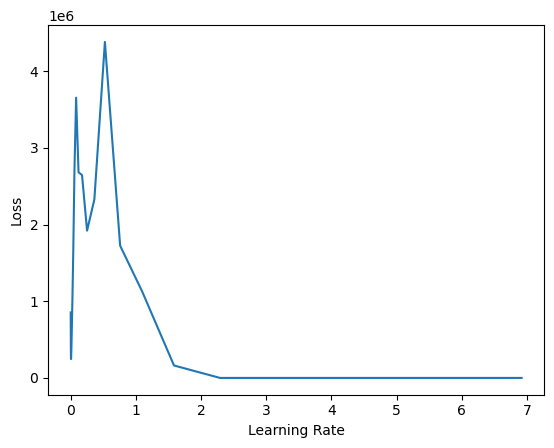

Optimal Learning Rate: 3.311311214825903


In [365]:
lr_finder(model=model_10, dataset=H_10, start_lr=1e-7, end_lr=10, num_iters=50)

In [232]:
loss_mean_10, acc_mean_10, models_10 = cross_val(
    dataset=H_10,
    model=model_10,
    folds=10,
    epochs=1600,
    lr=0.05,
    sched_max_lr=0.01,
    div_factor=5,  # init_lr = max_lr/div_factor 
    final_div_factor=2, # min_lr = init_lr/final_div_factor
    sched_steps=1300,
    sched=True,
    weight_decay=0.0005,
    late_start=1600,
    patience=50,
    min_delta=10,
    lr_decay_factor=0.5,
)


Transfering dataset to device cuda
Done
________________________________________________________________________________
Starting Cross Validation
________________________________________________________________________________
Transfering Model to devicecuda
Resetting parameters
Lazy Initialization of Model
Synchronizing GPU
Starting Training
fold : 0 | epoch : 1 | train_loss : 1668118.125 | val_loss : 1509864.5 | test_acc : 0.12 | 
--------------------------------------------------------------------------------
fold : 0 | epoch : 2 | train_loss : 1488919.625 | val_loss : 1332862.625 | test_acc : 0.12 | 
--------------------------------------------------------------------------------
fold : 0 | epoch : 3 | train_loss : 1308618.125 | val_loss : 1154677.125 | test_acc : 0.12 | 
--------------------------------------------------------------------------------
fold : 0 | epoch : 4 | train_loss : 1127044.0 | val_loss : 975167.8125 | test_acc : 0.12 | 
---------------------------------------

KeyboardInterrupt: 

In [ ]:
save_models(models_10, '.\\slac\\models_10\\')

Models saved to .\slac\models_10\


In [ ]:
model_10 = pyg_models.GraphSAGE(in_channels=-1, hidden_channels=64, num_layers=2, out_channels=len(set(lb_10.classes_)))
model_10 = to_hetero(model_10, H_10.metadata(), aggr='sum')
models_10 = load_models('.\\slac\\models_10\\', model_10, 5)

In [ ]:
winsound.Beep(400, 700)

In [225]:
predicted_10, mask_10 = voting(models_10, H_10)

predicted_10


array([7, 9, 5, 1, 4, 4, 5, 9, 1, 9, 9, 1, 1, 1, 7, 9, 7, 7, 8, 4, 7, 8,
       2, 4, 2, 4, 2, 8, 8, 0, 0, 5, 3, 5, 8, 0, 2, 6, 8, 8, 0, 4, 4, 4,
       2, 6, 2, 9, 4, 0], dtype=int64)

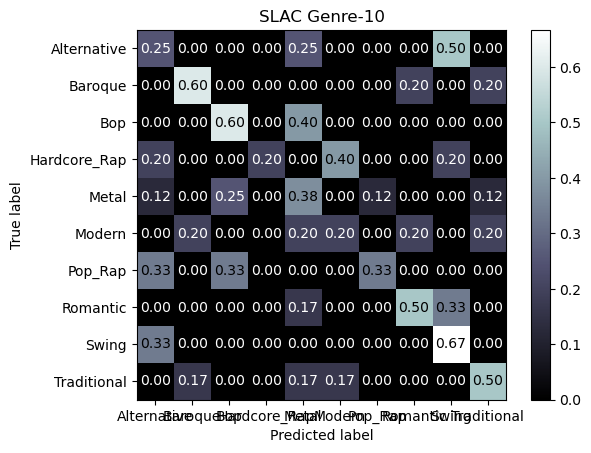

In [226]:
disp = ConfusionMatrixDisplay.from_predictions(y_true=lb_10.inverse_transform(H_10['MIDI'].y[mask_10].to('cpu')), y_pred=lb_10.inverse_transform(predicted_10), cmap='bone', normalize='true', values_format='.2f')

disp.ax_.set_title('SLAC Genre-10')
plt.show()

In [ ]:
import os
os.system('shutdown -s -t 60')

0

: 

# Old models

In [ ]:
def train_val_test(dataset, model, epochs, batch_size,
                                  lr, lr_decay_factor, lr_decay_step_size,
                                  weight_decay, logger=None, val=.1, test=.2, **kwargs):

    val_losses, accs, durations = [], [], []
    
    dataset = T.RandomNodeSplit(num_val=val, num_test=test)(dataset)
    
    train_dataset = dataset['MIDI'].x[dataset['MIDI'].train_mask]
    test_dataset = dataset['MIDI'].x[dataset['MIDI'].test_mask]
    val_dataset = dataset['MIDI'].x[dataset['MIDI'].val_mask]

    train_input_nodes = ('MIDI', train_dataset.to(torch.long))
    test_input_nodes = ('MIDI', test_dataset.to(torch.long))
    val_input_nodes = ('MIDI', val_dataset.to(torch.long))

    train_loader = HGTLoader(dataset, num_samples=[batch_size] * len(node_categories),
                            batch_size=batch_size, shuffle=True, input_nodes=train_input_nodes, **kwargs)
    val_loader = HGTLoader(dataset, num_samples=[batch_size] * len(node_categories),
                            batch_size=batch_size, shuffle=False, input_nodes=val_input_nodes, **kwargs)
    test_loader = HGTLoader(dataset, num_samples=[batch_size] * len(node_categories),
                            batch_size=batch_size, shuffle=False, input_nodes=test_input_nodes, **kwargs)

    model = model.to(device)
    reset_parameters(model)
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = F.cross_entropy

    if torch.cuda.is_available():
        torch.cuda.synchronize()

    t_start = time.perf_counter()


    for epoch in range(1, epochs + 1):
        train_loss = train(model, optimizer, loss_fn, train_loader)
        val_losses.append(eval_loss(model, loss_fn, val_loader))
        accs.append(eval_acc(model, test_loader))
        eval_info = {
            'fold': fold,
            'epoch': epoch,
            'train_loss': train_loss,
            'val_loss': val_losses[-1],
            'test_acc': accs[-1],
        }

        if logger is not None:
            logger(eval_info)

        if epoch % lr_decay_step_size == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_decay_factor * param_group['lr']

    if torch.cuda.is_available():
        torch.cuda.synchronize()

    t_end = time.perf_counter()
    durations.append(t_end - t_start)

    loss, acc, duration = tensor(val_losses), tensor(accs), tensor(durations)
    loss, acc = loss.view(folds, epochs), acc.view(folds, epochs)
    loss, argmin = loss.min(dim=1)
    acc = acc[torch.arange(folds, dtype=torch.long), argmin]

    loss_mean = loss.mean().item()
    acc_mean = acc.mean().item()
    acc_std = acc.std().item()
    duration_mean = duration.mean().item()
    print(f'Val Loss: {loss_mean:.4f}, Test Accuracy: {acc_mean:.3f} '
            f'± {acc_std:.3f}, Duration: {duration_mean:.3f}')

    return loss_mean, acc_mean, acc_std

In [ ]:
batch = next(iter(train_loader))

print(batch)


In [ ]:
optimizer_name = "Adam"
optimizer = torch.optim.Adam(model_5.parameters(), lr=0.01)
# optimizer = getattr(torch.optim, optimizer_name)(model_5.parameters(), lr=lr)


In [ ]:
def train5():
    model_5.train()
    optimizer.zero_grad()
    out = model_5(H_5.x_dict, H_5.edge_index_dict)
    mask = H_5['MIDI'].train_mask
    loss = F.cross_entropy(out['MIDI'][mask], H_5['MIDI'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)

In [ ]:
@torch.no_grad()
def test5():
    model_5.eval()
    pred = model_5(H_5.x_dict, H_5.edge_index_dict)['MIDI'].argmax(dim=-1)

    accs = []

    for mask in [H_5['MIDI'].train_mask, H_5['MIDI'].val_mask, H_5['MIDI'].test_mask]:
        accs.append(int((pred[mask] == H_5['MIDI'].y[mask]).sum()) / int(mask.sum()))
    return accs

In [ ]:
acc_lists = {'train': [], 'val': [], 'test': []}
loss_list = []

for epoch in range(1, 401):
    loss = train5()
    train_acc, val_acc, test_acc = test5()

    loss_list.append(loss)

    acc_lists['train'].append(train_acc)
    acc_lists['val'].append(val_acc)
    acc_lists['test'].append(test_acc)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 51338.9688, Train: 0.3850, Val: 0.4000, Test: 0.3200
Epoch: 002, Loss: 148168.7031, Train: 0.2350, Val: 0.2000, Test: 0.2000
Epoch: 003, Loss: 182329.5781, Train: 0.2150, Val: 0.1200, Test: 0.2800
Epoch: 004, Loss: 207378.8125, Train: 0.2150, Val: 0.1200, Test: 0.2800
Epoch: 005, Loss: 163439.0781, Train: 0.3900, Val: 0.2800, Test: 0.4000
Epoch: 006, Loss: 74914.2500, Train: 0.4600, Val: 0.4800, Test: 0.5600
Epoch: 007, Loss: 23919.3809, Train: 0.3650, Val: 0.5200, Test: 0.3600
Epoch: 008, Loss: 37908.1094, Train: 0.2200, Val: 0.3200, Test: 0.2400
Epoch: 009, Loss: 54425.4492, Train: 0.2050, Val: 0.2400, Test: 0.2000
Epoch: 010, Loss: 85370.6875, Train: 0.4200, Val: 0.4400, Test: 0.3600
Epoch: 011, Loss: 70373.0547, Train: 0.3550, Val: 0.3200, Test: 0.3200
Epoch: 012, Loss: 75915.6875, Train: 0.2050, Val: 0.2000, Test: 0.1600
Epoch: 013, Loss: 84191.1797, Train: 0.2950, Val: 0.3600, Test: 0.2400
Epoch: 014, Loss: 66786.6719, Train: 0.3600, Val: 0.5200, Test: 0.3200
Ep

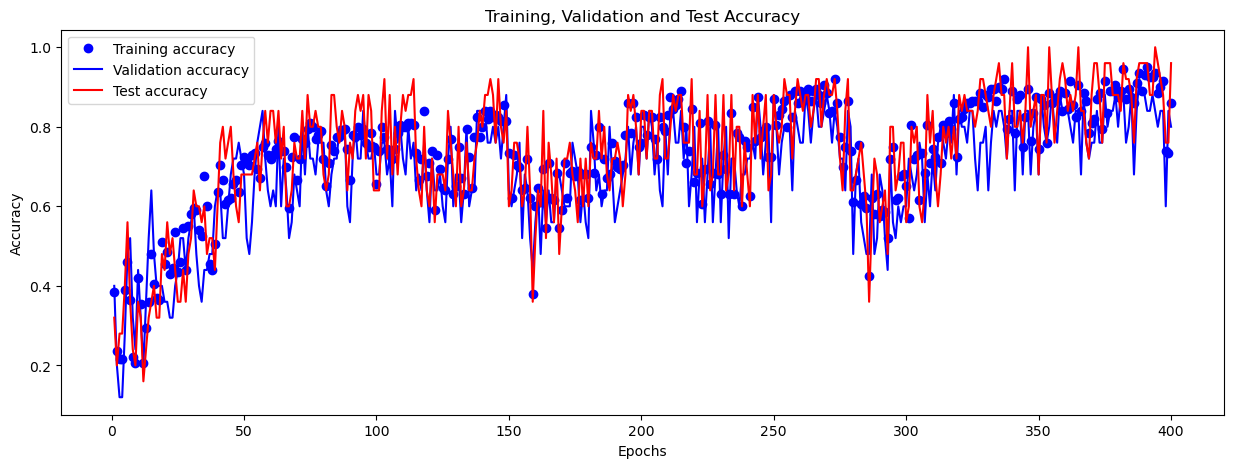

In [ ]:
plot_graph(acc_lists)

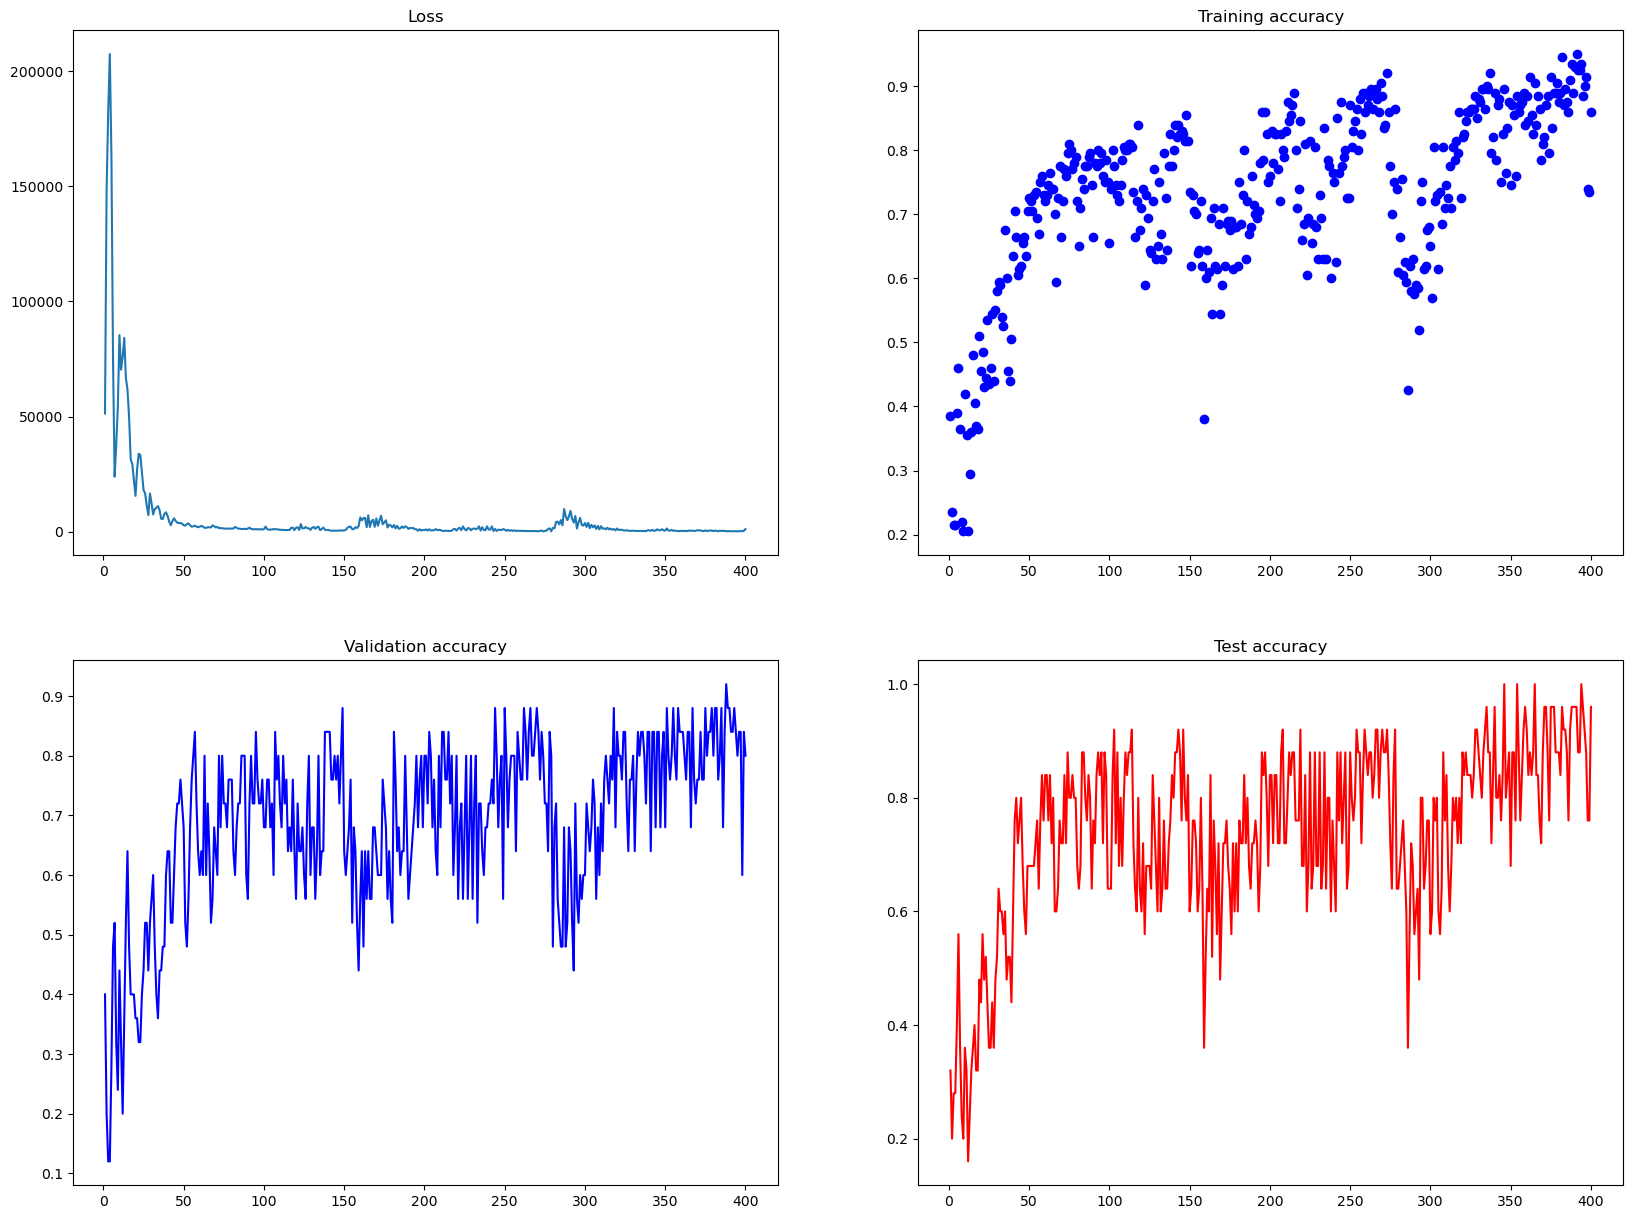

In [ ]:
plot_4graphs(loss_list, acc_lists)

In [ ]:
mask = H_5['MIDI'].test_mask

predicted = models[0](H_5.x_dict, H_5.edge_index_dict)['MIDI'].argmax(dim=-1)[mask]

predicted

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
        4, 4], device='cuda:0')

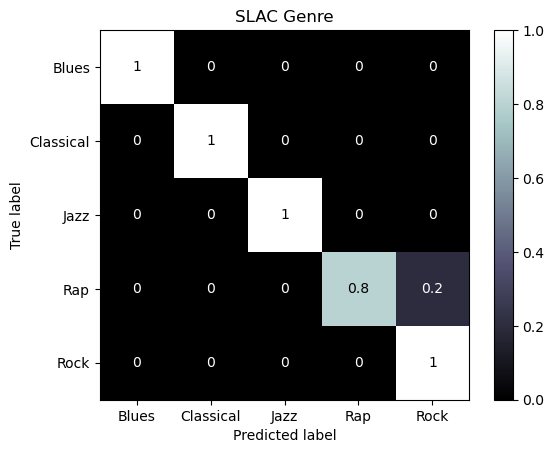

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_true=lb.inverse_transform(H_5['MIDI'].y[mask].to('cpu')), y_pred=lb.inverse_transform(predicted.to('cpu')), cmap='bone', normalize='true')

disp.ax_.set_title('SLAC Genre')
plt.show()

## 10 class

In [ ]:
nodes_df_complete.loc[nodes_df_complete['node_type'] == 'MIDI', ['name']]

,name
0,Blues_-_Modern-Albert_King_-_Born_Under_A_Bad_...
1029,Blues_-_Modern-B_B_King_-_How_Blue_Can_You_Get
2248,Blues_-_Modern-B_B_King_-_Rock_Me_Baby
2686,Blues_-_Modern-B_B_King_-_The_Thrill_Is_Gone
3738,Blues_-_Modern-Buddy_Guy_-_Don't_Answer_the_Door
...,...
92865,Rock_-_Metal-Rage_Against_the_Machine_-_Bulls_...
92925,Rock_-_Metal-Rage_Against_the_Machine_-_Gueril...
93030,Rock_-_Metal-Rage_Against_the_Machine_-_Killin...
93133,Rock_-_Metal-Rage_Against_the_Machine_-_Know_Y...


In [ ]:
set([midi_type(s[0], 10) for s in midi_val])

{'Alternative',
 'Baroque',
 'Bop',
 'Hardcore_Rap',
 'Metal',
 'Modern',
 'Pop_Rap',
 'Romantic',
 'Swing',
 'Traditional'}

In [ ]:
midi_class_10 = [midi_type(s[0], 10) for s in midi_val]

lb_10 = LabelEncoder()
y_10 = torch.from_numpy(lb_10.fit_transform(midi_class_10))  # .type(torch.LongTensor)

lb_10.classes_

array(['Alternative', 'Baroque', 'Bop', 'Hardcore_Rap', 'Metal', 'Modern',
       'Pop_Rap', 'Romantic', 'Swing', 'Traditional'], dtype='<U12')

In [ ]:
input_node_dict_10 = input_node_dict.copy()

input_node_dict_10['MIDI']['y'] = y_10

In [ ]:
H_10 = HeteroData(input_node_dict_10, **input_edge_dict).to(device)

In [ ]:
print(H_10)

HeteroData(
  pitch={ x=[93, 1] },
  duration={ x=[570, 1] },
  note_group={ x=[92484, 1] },
  tempo={ x=[23, 1] },
  time_sig={ x=[14, 1] },
  velocity={ x=[11, 1] },
  MIDI={
    x=[250, 1],
    y=[250]
  },
  program={ x=[108, 1] },
  (MIDI, has, tempo)={ edge_index=[2, 250] },
  (MIDI, in, time_sig)={ edge_index=[2, 239] },
  (MIDI, has, program)={ edge_index=[2, 1392] },
  (MIDI, has, note_group)={ edge_index=[2, 135160] },
  (note_group, has, velocity)={ edge_index=[2, 118626] },
  (note_group, has, duration)={ edge_index=[2, 92484] },
  (note_group, contains, pitch)={ edge_index=[2, 438484] }
)


In [ ]:
H_10 = T.ToUndirected()(H_10)

In [ ]:
H_10 = T.RandomNodeSplit(num_val=0.1, num_test=0.1)(H_10)

In [ ]:
print(H_10)

HeteroData(
  pitch={ x=[93, 1] },
  duration={ x=[570, 1] },
  note_group={ x=[92484, 1] },
  tempo={ x=[23, 1] },
  time_sig={ x=[14, 1] },
  velocity={ x=[11, 1] },
  MIDI={
    x=[250, 1],
    y=[250],
    train_mask=[250],
    val_mask=[250],
    test_mask=[250]
  },
  program={ x=[108, 1] },
  (MIDI, has, tempo)={ edge_index=[2, 250] },
  (MIDI, in, time_sig)={ edge_index=[2, 239] },
  (MIDI, has, program)={ edge_index=[2, 1392] },
  (MIDI, has, note_group)={ edge_index=[2, 135160] },
  (note_group, has, velocity)={ edge_index=[2, 118626] },
  (note_group, has, duration)={ edge_index=[2, 92484] },
  (note_group, contains, pitch)={ edge_index=[2, 438484] },
  (tempo, rev_has, MIDI)={ edge_index=[2, 250] },
  (time_sig, rev_in, MIDI)={ edge_index=[2, 239] },
  (program, rev_has, MIDI)={ edge_index=[2, 1392] },
  (note_group, rev_has, MIDI)={ edge_index=[2, 135160] },
  (velocity, rev_has, note_group)={ edge_index=[2, 118626] },
  (duration, rev_has, note_group)={ edge_index=[2, 924

In [ ]:
model_10 = GCN(hidden_channels=64, out_channels=len(set(lb_10.classes_)), drop_layer=True)
model_10 = to_hetero(model_10, H_10.metadata(), aggr='sum')
model_10.to(device)

GraphModule(
  (conv1): ModuleDict(
    (MIDI__has__tempo): SAGEConv((-1, -1), 64, aggr=mean)
    (MIDI__in__time_sig): SAGEConv((-1, -1), 64, aggr=mean)
    (MIDI__has__program): SAGEConv((-1, -1), 64, aggr=mean)
    (MIDI__has__note_group): SAGEConv((-1, -1), 64, aggr=mean)
    (note_group__has__velocity): SAGEConv((-1, -1), 64, aggr=mean)
    (note_group__has__duration): SAGEConv((-1, -1), 64, aggr=mean)
    (note_group__contains__pitch): SAGEConv((-1, -1), 64, aggr=mean)
    (tempo__rev_has__MIDI): SAGEConv((-1, -1), 64, aggr=mean)
    (time_sig__rev_in__MIDI): SAGEConv((-1, -1), 64, aggr=mean)
    (program__rev_has__MIDI): SAGEConv((-1, -1), 64, aggr=mean)
    (note_group__rev_has__MIDI): SAGEConv((-1, -1), 64, aggr=mean)
    (velocity__rev_has__note_group): SAGEConv((-1, -1), 64, aggr=mean)
    (duration__rev_has__note_group): SAGEConv((-1, -1), 64, aggr=mean)
    (pitch__rev_contains__note_group): SAGEConv((-1, -1), 64, aggr=mean)
  )
  (conv2): ModuleDict(
    (MIDI__has__tempo

In [ ]:
optimizer_10 = torch.optim.Adam(model_10.parameters(), lr=0.01)

In [ ]:
def train10():
    model_10.train()
    optimizer_10.zero_grad()
    out = model_10(H_10.x_dict, H_10.edge_index_dict)
    mask = H_10['MIDI'].train_mask
    loss = F.cross_entropy(out['MIDI'][mask], H_10['MIDI'].y[mask])
    loss.backward()
    optimizer_10.step()
    return float(loss)

In [ ]:
@torch.no_grad()
def test10():
    model_10.eval()
    pred = model_10(H_10.x_dict, H_10.edge_index_dict)['MIDI'].argmax(dim=-1)

    accs = []
    for mask in [H_10['MIDI'].train_mask, H_10['MIDI'].val_mask, H_10['MIDI'].test_mask]:
        accs.append(int((pred[mask] == H_10['MIDI'].y[mask]).sum()) / int(mask.sum()))
    return accs

In [ ]:
acc_lists = {'train': [], 'val': [], 'test': []}
loss_list = []
for epoch in range(1, 801):
    loss = train10()
    train_acc, val_acc, test_acc = test10()

    loss_list.append(loss)

    acc_lists['train'].append(train_acc)
    acc_lists['val'].append(val_acc)
    acc_lists['test'].append(test_acc)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 321662.5625, Train: 0.1250, Val: 0.0800, Test: 0.0800
Epoch: 002, Loss: 358153.1250, Train: 0.1500, Val: 0.1600, Test: 0.0400
Epoch: 003, Loss: 342014.0000, Train: 0.1150, Val: 0.1200, Test: 0.2000
Epoch: 004, Loss: 276464.8750, Train: 0.1000, Val: 0.2400, Test: 0.0400
Epoch: 005, Loss: 281832.8750, Train: 0.0750, Val: 0.2000, Test: 0.0800
Epoch: 006, Loss: 236875.9062, Train: 0.0950, Val: 0.2400, Test: 0.1600
Epoch: 007, Loss: 217711.7031, Train: 0.0750, Val: 0.2800, Test: 0.2400
Epoch: 008, Loss: 212563.9375, Train: 0.0950, Val: 0.1200, Test: 0.0800
Epoch: 009, Loss: 165928.5156, Train: 0.1350, Val: 0.0400, Test: 0.2000
Epoch: 010, Loss: 149308.3125, Train: 0.0500, Val: 0.0800, Test: 0.2400
Epoch: 011, Loss: 132843.3438, Train: 0.1300, Val: 0.0800, Test: 0.1200
Epoch: 012, Loss: 176128.2344, Train: 0.1950, Val: 0.0800, Test: 0.0400
Epoch: 013, Loss: 143326.3906, Train: 0.1550, Val: 0.1200, Test: 0.1600
Epoch: 014, Loss: 146115.5156, Train: 0.1900, Val: 0.2400, Test:

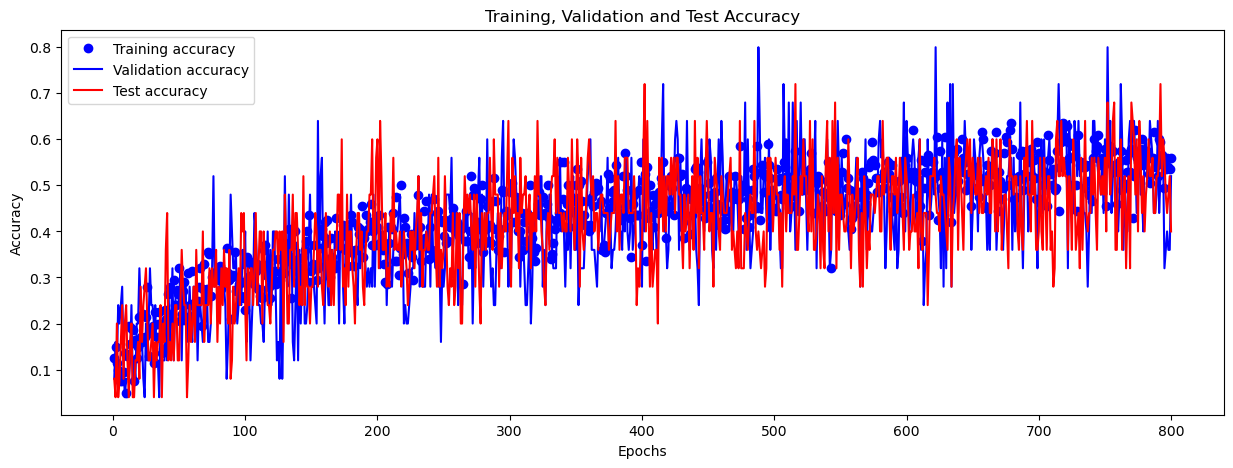

In [ ]:
plot_graph(acc_lists)

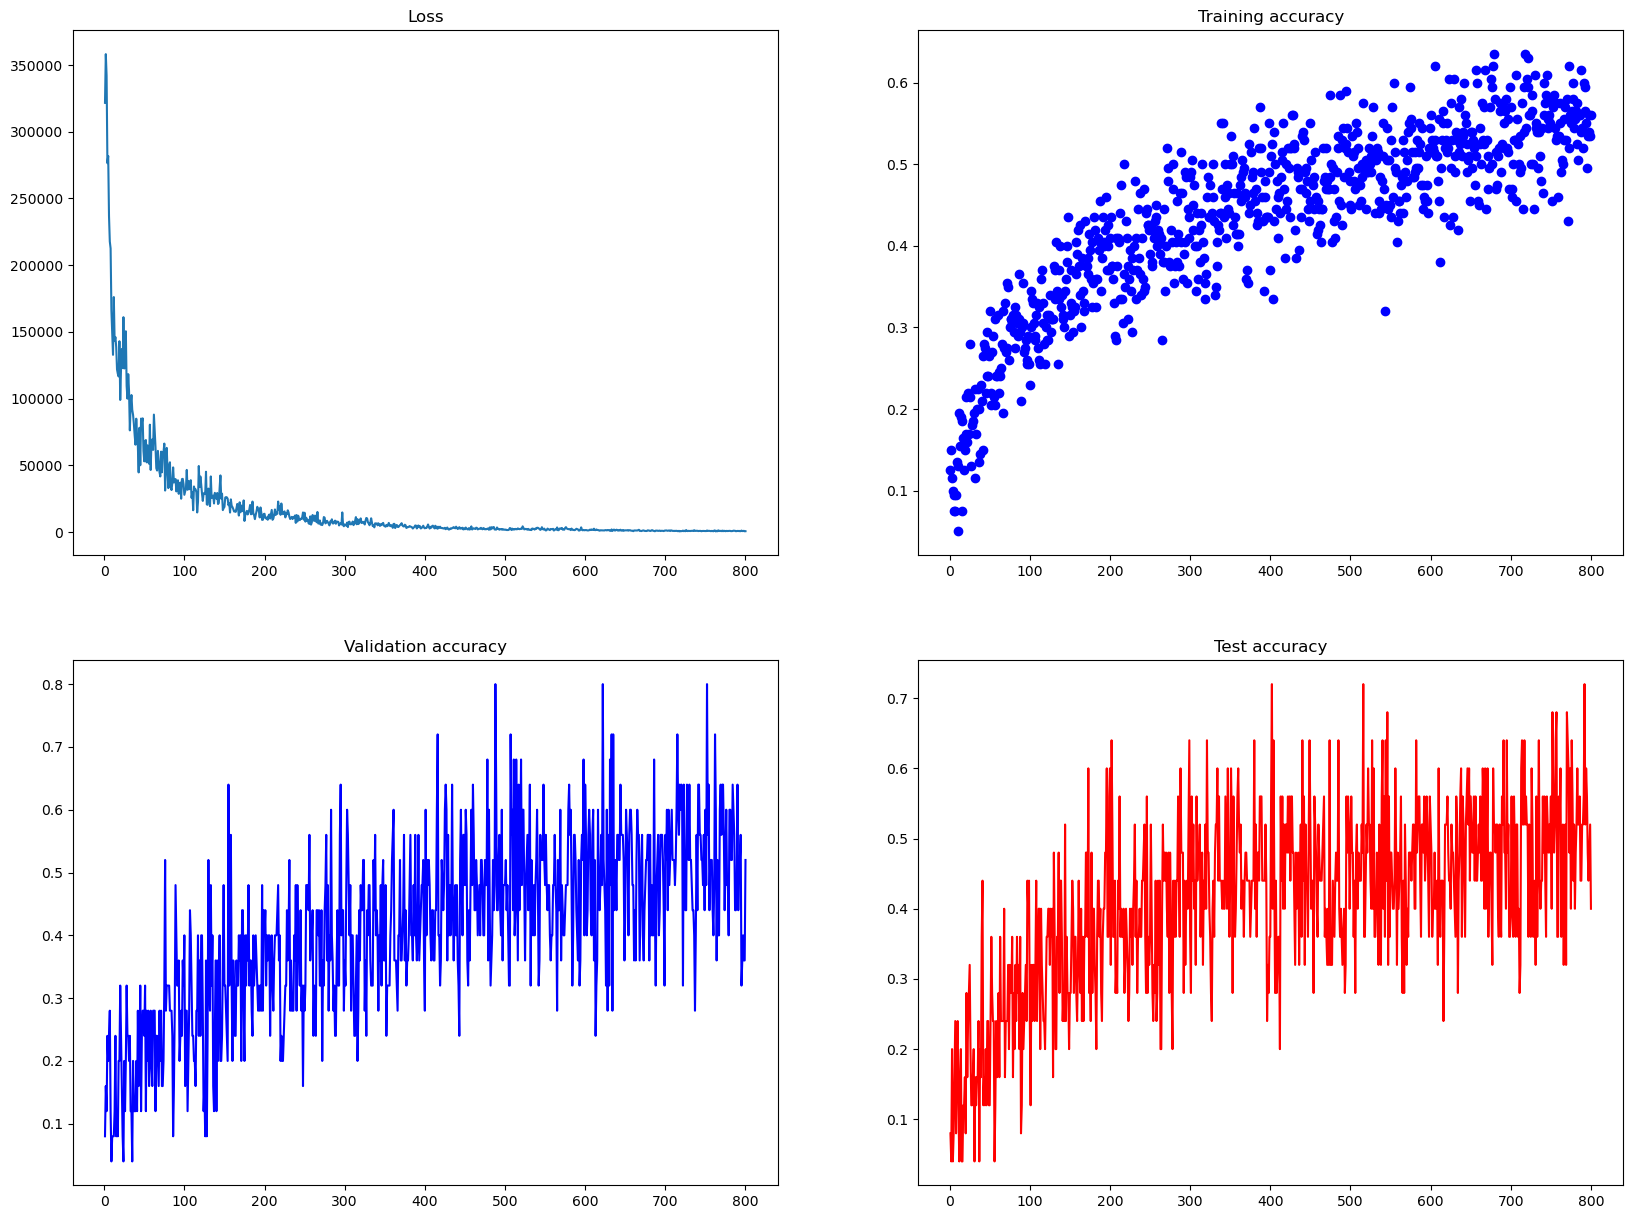

In [ ]:
plot_4graphs(loss_list, acc_lists)

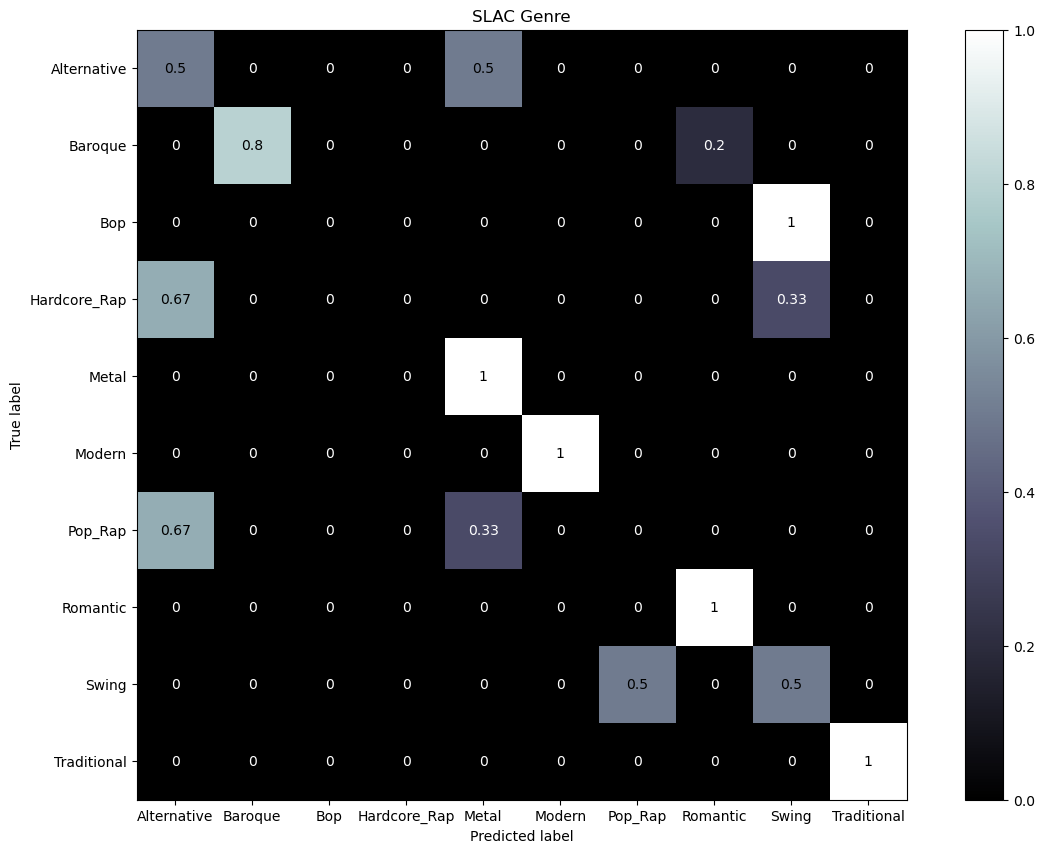

In [ ]:
mask = H_10['MIDI'].test_mask

predicted = model_10(H_10.x_dict, H_10.edge_index_dict)['MIDI'].argmax(dim=-1)[mask]

predicted
disp = ConfusionMatrixDisplay.from_predictions(y_true=lb_10.inverse_transform(H_10['MIDI'].y[mask].to('cpu')),
                                               y_pred=lb_10.inverse_transform(predicted.to('cpu')), cmap='bone',
                                               normalize='true')

disp.ax_.set_title('SLAC Genre')
disp.figure_.set_size_inches(15, 10)
plt.show()

 # Old Implementation

In [ ]:
# def cross_validation_with_val_set(dataset, model, folds, epochs, batch_size,
#                                   lr, lr_decay_factor, lr_decay_step_size,
#                                   weight_decay, logger=None):

#     val_losses, accs, durations = [], [], []
#     for fold, (train_idx, test_idx,
#                val_idx) in enumerate(zip(*k_fold(dataset, folds))):

#         dataset['MIDI'].train_mask = train_idx
#         dataset['MIDI'].val_mask = val_idx
#         dataset['MIDI'].test_mask = test_idx

#         train_dataset = dataset['MIDI'].x[dataset['MIDI'].train_mask]
#         test_dataset = dataset['MIDI'].x[dataset['MIDI'].test_mask]
#         val_dataset = dataset['MIDI'].x[dataset['MIDI'].val_mask]

#         train_input_nodes = ('MIDI', train_dataset.to(torch.long))
#         test_input_nodes = ('MIDI', test_dataset.to(torch.long))
#         val_input_nodes = ('MIDI', val_dataset.to(torch.long))

#         train_loader = HGTLoader(dataset, num_samples=[batch_size] * len(node_categories),
#                                 batch_size=batch_size, shuffle=True, input_nodes=train_input_nodes)
#         val_loader = HGTLoader(dataset, num_samples=[batch_size] * len(node_categories),
#                                 batch_size=batch_size, shuffle=False, input_nodes=val_input_nodes)
#         test_loader = HGTLoader(dataset, num_samples=[batch_size] * len(node_categories),
#                                 batch_size=batch_size, shuffle=False, input_nodes=test_input_nodes)

#         model = model.to(device)
#         model._init_weights()
#         optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
#         loss_fn = F.cross_entropy

#         if torch.cuda.is_available():
#             torch.cuda.synchronize()

#         t_start = time.perf_counter()


#         for epoch in range(1, epochs + 1):
#             train_loss = train(model, optimizer, loss_fn, train_loader)
#             val_losses.append(eval_loss(model, loss_fn, val_loader))
#             accs.append(eval_acc(model, test_loader))
#             eval_info = {
#                 'fold': fold,
#                 'epoch': epoch,
#                 'train_loss': train_loss,
#                 'val_loss': val_losses[-1],
#                 'test_acc': accs[-1],
#             }

#             if logger is not None:
#                 logger(eval_info)

#             if epoch % lr_decay_step_size == 0:
#                 for param_group in optimizer.param_groups:
#                     param_group['lr'] = lr_decay_factor * param_group['lr']

#         if torch.cuda.is_available():
#             torch.cuda.synchronize()

#         t_end = time.perf_counter()
#         durations.append(t_end - t_start)

#     loss, acc, duration = tensor(val_losses), tensor(accs), tensor(durations)
#     loss, acc = loss.view(folds, epochs), acc.view(folds, epochs)
#     loss, argmin = loss.min(dim=1)
#     acc = acc[torch.arange(folds, dtype=torch.long), argmin]

#     loss_mean = loss.mean().item()
#     acc_mean = acc.mean().item()
#     acc_std = acc.std().item()
#     duration_mean = duration.mean().item()
#     print(f'Val Loss: {loss_mean:.4f}, Test Accuracy: {acc_mean:.3f} '
#           f'± {acc_std:.3f}, Duration: {duration_mean:.3f}')

#     return loss_mean, acc_mean, acc_std


# def k_fold(dataset, folds):
#     skf = KFold(folds, shuffle=True, random_state=42)

#     test_indices, train_indices = [], []
#     for _, idx in skf.split(torch.zeros(len(dataset['MIDI'].x)), dataset['MIDI'].y):
#         test_indices.append(torch.from_numpy(idx).to(torch.long))

#     val_indices = [test_indices[i - 1] for i in range(folds)]


#     for i in range(folds):
#         train_mask = torch.ones(len(dataset['MIDI'].x), dtype=torch.bool)
#         train_mask[test_indices[i]] = 0
#         train_mask[val_indices[i]] = 0
#         train_indices.append(train_mask.nonzero(as_tuple=False).view(-1))

#     return train_indices, test_indices, val_indices

# def reset_parameters(model):
#     for layer in model.children():
#         if hasattr(layer, 'reset_parameters'):
#             layer.reset_parameters()

# def num_graphs(data):
#     if hasattr(data, 'num_graphs'):
#         return data.num_graphs
#     else:
#         return data.x.size(0)


# def train(model, optimizer, loss_fn, loader):
#     model.train()

#     total_loss = 0
#     for data in loader:
#         optimizer.zero_grad()
#         data = data.to(device)
#         out = model(data.x_dict, data.edge_index_dict)
#         loss = loss_fn(out, data.y.view(-1))
#         loss.backward()
#         total_loss += loss.item() * num_graphs(data)
#         optimizer.step()
#     return total_loss / len(loader.dataset)


# def eval_acc(model, loader):
#     model.eval()

#     correct = 0
#     for data in loader:
#         data = data.to(device)
#         with torch.no_grad():
#             pred = model(data.x_dict, data.edge_index_dict)['MIDI'].argmax(dim=-1)
#         correct += pred.eq(data.y.view(-1)).sum().item()
#     return correct / len(loader.dataset)


# def eval_loss(model, loss_fn, loader):
#     model.eval()

#     loss = 0
#     for data in loader:
#         data = data.to(device)
#         with torch.no_grad():
#             out = model(data.x_dict, data.edge_index_dict)
#         loss += loss_fn(out, data.y.view(-1), reduction='sum').item()
#     return loss / len(loader.dataset)


# @torch.no_grad()
# def inference_run(model, loader, bf16):
#     model.eval()
#     for data in loader:
#         data = data.to(device)
#         if bf16:
#             data.x = data.x.to(torch.bfloat16)
#         model(data)


In [ ]:
# #rewrite the function above without train_mask and test_mask
#  def train_epoch5(model, device, dataloader, loss_fn, optimizer):
#     train_loss, train_correct = 0.0, 0
#     model.train()
#     for batch in dataloader:
#         batch = batch.to(device)
#         optimizer.zero_grad()
#         out = model(batch.x_dict, batch.edge_index_dict)
#         loss = loss_fn(out['MIDI'], batch['MIDI'].y)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item() * batch['MIDI'].num_nodes
#         scores, predictions = torch.max(out['MIDI'].data, 1)
#         train_correct += (predictions == batch['MIDI'].y).sum().item()
#     return train_loss, train_correct
#
#
# def valid_epoch5(model, device, dataloader, loss_fn):
#     valid_loss, val_correct = 0.0, 0
#     model.eval()
#     with torch.no_grad():
#         for batch in dataloader:
#             batch = batch.to(device)
#             output = model(batch.x_dict, batch.edge_index_dict)
#             loss = loss_fn(output['MIDI'], batch['MIDI'].y)
#             valid_loss += loss.item() * batch['MIDI'].num_nodes
#             scores, predictions = torch.max(output['MIDI'][mask].data, 1)
#             val_correct += (predictions == batch['MIDI'].y[mask]).sum().item()
#
#     return valid_loss, val_correct
#
#
# # define a training and testing function using kfold cross validation and torch.utils.data.DataLoader and prints the outputs for each iteration
# def train5(model, device, train_loader, test_loader, loss_fn, optimizer, epochs):
#     train_losses, train_corrects = [], []
#     val_losses, val_corrects = [], []
#     for epoch in range(epochs):
#         train_loss, train_correct = train_epoch5(model, device, train_loader, loss_fn, optimizer)
#         valid_loss, val_correct = valid_epoch5(model, device, test_loader, loss_fn)
#         train_losses.append(train_loss)
#         train_corrects.append(train_correct)
#         val_losses.append(valid_loss)
#         val_corrects.append(val_correct)
#         print(f'Epoch: {epoch + 1:02}')
#         print(f'\tTrain Loss: {train_loss:.4f} | Train Acc: {train_correct / len(train_loader.dataset):.4f}')
#         print(f'\t Val. Loss: {valid_loss:.4f} |  Val. Acc: {val_correct / len(test_loader.dataset):.4f}')
#     return train_losses, train_corrects, val_losses, val_corrects
#

# now write the code to run the above functions and define the parameters before the function call
# define the parameters
# loss_fn = F.cross_entropy
# optimizer = torch.optim.Adam(model_5.parameters(), lr=0.01)
# train_loader = DataLoader(H_5, batch_size=128, shuffle=True)
# test_loader = DataLoader(H_5, batch_size=128, shuffle=False)
#
# train5(model_5, device, train_loader, test_loader, loss_fn, optimizer, epochs=10)

In [ ]:
# nodes_ten_ = encoder.encode_nodes(nodes_df_complete)
# edges_ten_ = encoder.encode_edges(edges_df_complete)

# node_type_ = nodes_df_complete.iloc[:, 1]

# Get the source and target indices from the edges tensor
# edge_index = edges_ten_[:, :2]

## Get the edge types from the edges tensor
#edge_type_ = edges_df_complete.iloc[:, 2]

#full_hetero_graph = HeteroData(x=nodes_ten_, node_type=node_type_, edge_index=edge_index, edge_type=edge_type_)

In [ ]:
# edges_df_complete.loc[edges_df_complete['edge_type'] == 'MIDI__has__tempo', ['source', 'target']]

In [ ]:
# full_categories = node_categories.copy()
# full_categories['node_types'] = list(node_categories.keys())
# full_categories['edge_types'] = edge_types  # Dictionary containing every string that may be found in our Dataframes
# names_list_full = flatten_lol(full_categories.values())

In [ ]:
# input_edge_dict = {edge_type: {'edge_index': encoder.encode_edges(edges_df_complete.loc[
#                    edges_df_complete['edge_type'] == edge_type, ['source', 'target']])} for edge_type in edge_types}
# for key in input_edge_dict.keys():
#     input_edge_dict[key]['edge_index'] = input_edge_dict[key]['edge_index'].T.to(torch.int64)
